In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from scipy import stats
import matplotlib.pyplot as plt

# feel free not to use cupy if you don't have a CUDA gpu on your machine.
import cupy as cp

In [2]:
DATA_PATH = '../data/nwp/surface_data.zarr'
# here is an example: 'C:/Users/areel/watai/watai_repo/data/nwp/atmosphere/2022/01'

In [3]:
dataset = xr.open_dataset(DATA_PATH, engine='zarr', chunks='auto')

In [4]:
dataset

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Data variables: (12/223)
    alnid      (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    alnip      (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    aluvd      (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    aluvp      (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    anor       (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    asn        (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    ...         ...
    wmb        (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wsk        (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wsp        (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wss        (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    z          (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    zust       (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-26 09:57:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

As seen above, the data seems simpler since it doesn't have a "level" index adding another dimension. Lets dive a bit deeper into the data.

In [5]:
dataset.coords

Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00

In [6]:
dataset.dims

Frozen({'time': 24, 'latitude': 721, 'longitude': 1440})

In [7]:
dataset.indexes

Indexes:
    latitude   Float64Index([  90.0,  89.75,   89.5,  89.25,   89.0,  88.75,   88.5,  88.25,
                88.0,  87.75,
              ...
              -87.75,  -88.0, -88.25,  -88.5, -88.75,  -89.0, -89.25,  -89.5,
              -89.75,  -90.0],
             dtype='float64', name='latitude', length=721)
    longitude  Float64Index([   0.0,   0.25,    0.5,   0.75,    1.0,   1.25,    1.5,   1.75,
                 2.0,   2.25,
              ...
               357.5, 357.75,  358.0, 358.25,  358.5, 358.75,  359.0, 359.25,
               359.5, 359.75],
             dtype='float64', name='longitude', length=1440)
    time       DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               '2022-01-01 10:00:00', '2022-01-01 1

Once again, lets check out the different variables.

In [30]:
variable_names = list(dataset.variables)

In [33]:
starting_time = dataset.indexes['time'][0]
data = dataset.sel(time=starting_time)
for v in variable_names:
    print(f'Variable name: {v}, Description: {data[v].attrs["long_name"]}, Units: {(data[v].attrs["units"] if "units" in data[v].attrs else "N/A")}')

Variable name: alnid, Description: Near IR albedo for diffuse radiation, Units: (0 - 1)
Variable name: alnip, Description: Near IR albedo for direct radiation, Units: (0 - 1)
Variable name: aluvd, Description: UV visible albedo for diffuse radiation, Units: (0 - 1)
Variable name: aluvp, Description: UV visible albedo for direct radiation, Units: (0 - 1)
Variable name: anor, Description: Angle of sub-gridscale orography, Units: radians
Variable name: asn, Description: Snow albedo, Units: (0 - 1)
Variable name: bfi, Description: Benjamin-Feir index, Units: dimensionless
Variable name: bld, Description: Boundary layer dissipation, Units: J m**-2
Variable name: blh, Description: Boundary layer height, Units: m
Variable name: cape, Description: Convective available potential energy, Units: J kg**-1
Variable name: cbh, Description: Cloud base height, Units: m
Variable name: cdir, Description: Clear-sky direct solar radiation at surface, Units: J m**-2
Variable name: cdww, Description: Coeffi

That's quite a lot of variables. 226 in total. We will probably not be using all 226 variables in our model but we will have to figure out which variables are strongly correlated with the PV data and which aren't.

Lets get some stats on the dataset now.

In [49]:
variable_names.remove('time')

for v in variable_names:
    data = cp.asarray(dataset.variables[v].values.flatten())
    print(f'{v}: (min={cp.nanmin(data)} max={cp.nanmax(data)} mean={cp.nanmean(data)} median={cp.nanmedian(data)} var={cp.nanvar(data)} std={cp.nanstd(data)})')

alnid: (min=0.040603697299957275 max=0.6874983310699463 mean=0.10808108001947403 median=0.06000077724456787 var=0.007027533836662769 std=0.08383038640022278)
alnip: (min=0.037059485912323 max=0.6712049245834351 mean=0.10385676473379135 median=0.06001269817352295 var=0.0059760622680187225 std=0.07730499655008316)
aluvd: (min=0.011913120746612549 max=0.941582441329956 mean=0.07540600746870041 median=0.060004591941833496 var=0.0018862101715058088 std=0.043430522084236145)
aluvp: (min=0.010089576244354248 max=0.941583514213562 mean=0.07401339709758759 median=0.05999535322189331 var=0.0017835870385169983 std=0.042232535779476166)
anor: (min=-1.56938636302948 max=1.5685112476348877 mean=0.5164154767990112 median=0.7853895425796509 var=0.31902825832366943 std=0.5648258924484253)
asn: (min=0.5199999213218689 max=0.8800005316734314 mean=0.8624014258384705 median=0.8800005316734314 var=0.0023301485925912857 std=0.04827161133289337)
bfi: (min=-10.000000953674316 max=10.000061988830566 mean=0.0877

Cool, now lets see which variables have NaN values (50 of them do!)

In [50]:
for v in variable_names:
    data = cp.asarray(dataset.variables[v].values)
    if cp.isnan(data).any():
        print(f'{v} has {cp.count_nonzero(cp.isnan(data))} NaN values!')

bfi has 21485208 NaN values!
cbh has 4006951 NaN values!
cdww has 20795400 NaN values!
cin has 21369714 NaN values!
dwi has 20794920 NaN values!
dwps has 21485208 NaN values!
dwww has 21485208 NaN values!
hmax has 21485208 NaN values!
mdts has 21485208 NaN values!
mdww has 21485208 NaN values!
mp1 has 21485208 NaN values!
mp2 has 21485208 NaN values!
mpts has 21485208 NaN values!
mpww has 21485208 NaN values!
msqs has 21485208 NaN values!
mwd has 21485208 NaN values!
mwp has 21485208 NaN values!
p140121 has 21485580 NaN values!
p140122 has 21485580 NaN values!
p140123 has 21485580 NaN values!
p140124 has 21485580 NaN values!
p140125 has 21485580 NaN values!
p140126 has 21485580 NaN values!
p140127 has 21485580 NaN values!
p140128 has 21485580 NaN values!
p140129 has 21485580 NaN values!
p140208 has 20795400 NaN values!
p140209 has 20795400 NaN values!
p1ps has 21485208 NaN values!
p1ww has 21485208 NaN values!
p2ps has 21485208 NaN values!
p2ww has 21485208 NaN values!
phiaw has 207954

Interesting... lets see what they look like if they do have NaN values. What does the data look like?

In [63]:
data = dataset.variables['swh'].values
data

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [76]:
print("Percentage of NaN values in the swh variable:", len(data[~np.isnan(data)]) * 100 / np.prod(data.shape))

Percentage of NaN values in the swh variable: 13.775523963630759


In [54]:
data[~np.isnan(data)]

array([0.04820251, 0.04820251, 0.04820251, ..., 0.04837847, 0.04837847,
       0.25960302], dtype=float32)

So there are a decent amount of non-NaN values in these variables, however they only exist at certain latitudes/longitudes. Lets visualize these values.

In [160]:
# Reshape the array such that the prime meridian (longitude=0) is centered on the map
def center_at_prime_meridean(variable_data):
    for i in range(len(variable_data)):
        first_half = variable_data[i][:len(variable_data // 2)]
        second_half = variable_data[i][len(variable_data // 2):]
        variable_data[i] = np.concatenate([second_half, first_half])
    return variable_data

nan_data = dataset.sel(time=starting_time)['swh'].values

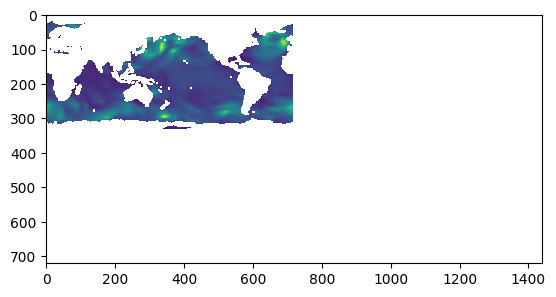

In [161]:
plt.imshow(cp.asnumpy(nan_data))

Weird... looks like the data isn't properly "cropped". I will bring this up in the meeting. So lets crop it and redo it.

In [162]:
for e, i in enumerate(reversed(~np.isnan(nan_data)[200])):
    if i:
        print("longitude border:", len(~np.isnan(nan_data)[200]) - e)
        break

longitude border: 720


In [163]:
# which means the latitude should end at 360

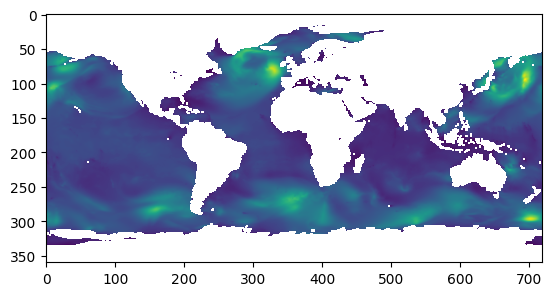

In [164]:
nan_data = nan_data[0:360, 0:720]
plt.imshow(center_at_prime_meridean(nan_data))

So it turns out that it has NaN values since it maps values to the water and isn't "cropped" correctly. Keep that in mind. Lets see if this is the case with the other NaN variables.

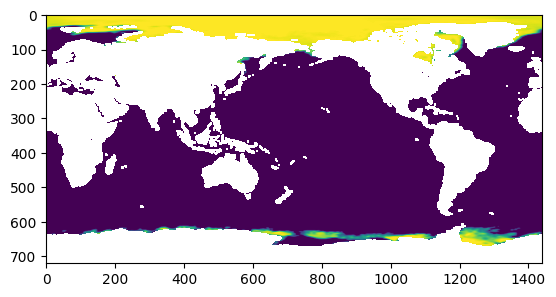

In [168]:
plt.imshow(dataset.sel(time=starting_time)['siconc'].values)

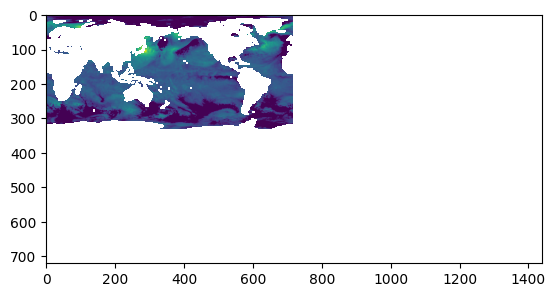

In [169]:
plt.imshow(dataset.sel(time=starting_time)['p140208'].values)

So it seems to be an issue for some variables, but not others. The variables with ~21485208 NaN values seem to be "incorrectly cropped" while the variables with ~8445024 NaN values are "correctly cropped" but still have NaN values due to not having data for land but only water.

Lets create some functions to plot the variables.

In [170]:
def plot_variable_daily_mean(variable_name):
    variable_data = center_at_prime_meridean(dataset[variable_name].values.mean(axis=0))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    im = plt.imshow(variable_data, extent=[-180,180,-90,90])
    plt.colorbar(im, fraction=0.022, pad=0.01)

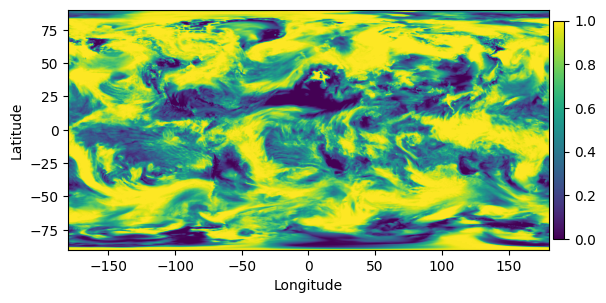

In [174]:
plot_variable_daily_mean('tcc')

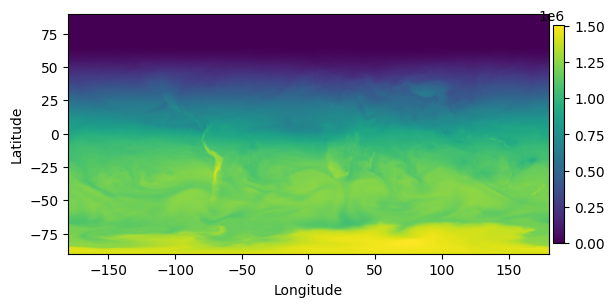

In [183]:
plot_variable_daily_mean('cdir')
# keep in mind this is the daily mean of direct sun radiation. it makes sense that the south would get a daily average of 100% sun while the far north would get 0% sun for a full day due to how the earth is tilted. this would change in the seasons.

'tcc' might be a variable we'll use for our model - it represents a % of total cloud cover over the land.
'cdir' might also be useful - the amount of direct radiation from the sun assuming a clear sky.

In [250]:
def plot_over_map(variable, starting_time):
    overlay = plt.imread('./world_scaled_for_lat_long.png')[145:455, 99:721]
    variable_data = center_at_prime_meridean(dataset.sel(time=starting_time)[variable].values)

    plt.imshow(overlay, extent=[-180,180,-90,90])
    im = plt.imshow(variable_data, extent=[-180,180,-90,90], alpha=0.8)
    plt.colorbar(im, fraction=0.022, pad=0.01)

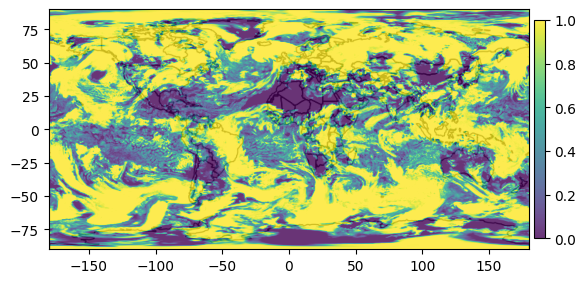

In [251]:
plot_over_map('tcc', starting_time) # total cloud cover on the surface.

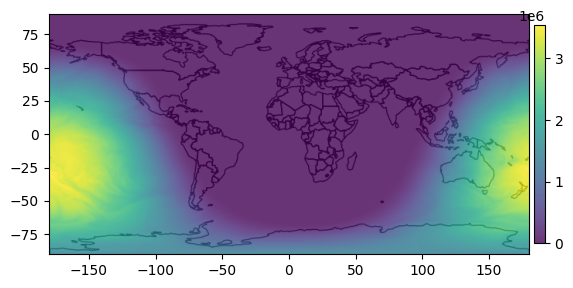

In [252]:
plot_over_map('cdir', starting_time) # Clear-sky direct solar radiation at surface

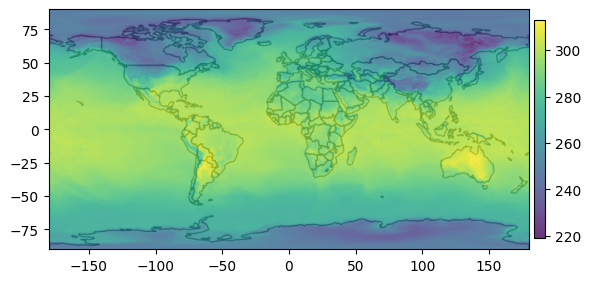

In [253]:
plot_over_map('t2m', starting_time) # 2 metre temperature

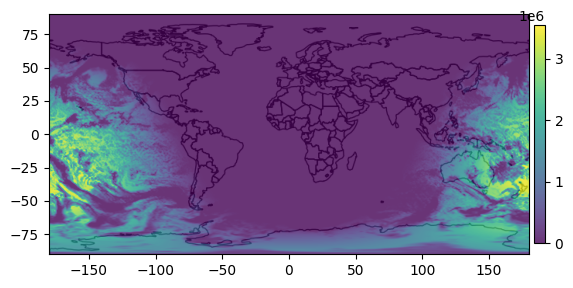

In [255]:
plot_over_map('fdir', starting_time) # Total sky direct solar radiation at surface

Now for another function to plot the data over a time interval.

In [185]:
def plot_time_intervals(variable, starting_time, intervals=6, columns=2, rows=3, d=1):
    columns = int(intervals / rows)
    fig = plt.figure(figsize=(15, 15))
    delta = datetime.timedelta(hours=d)

    for i in range(1, columns*rows + 1):
        time_slice = starting_time + delta * (i - 1)
        variable_data = center_at_prime_meridean(dataset.sel(time=time_slice)[variable].values)
        fig.add_subplot(rows, columns, i, title=time_slice)
        im = plt.imshow(variable_data, extent=[-180,180,-90,90])
        plt.colorbar(im, fraction=0.022, pad=0.01)

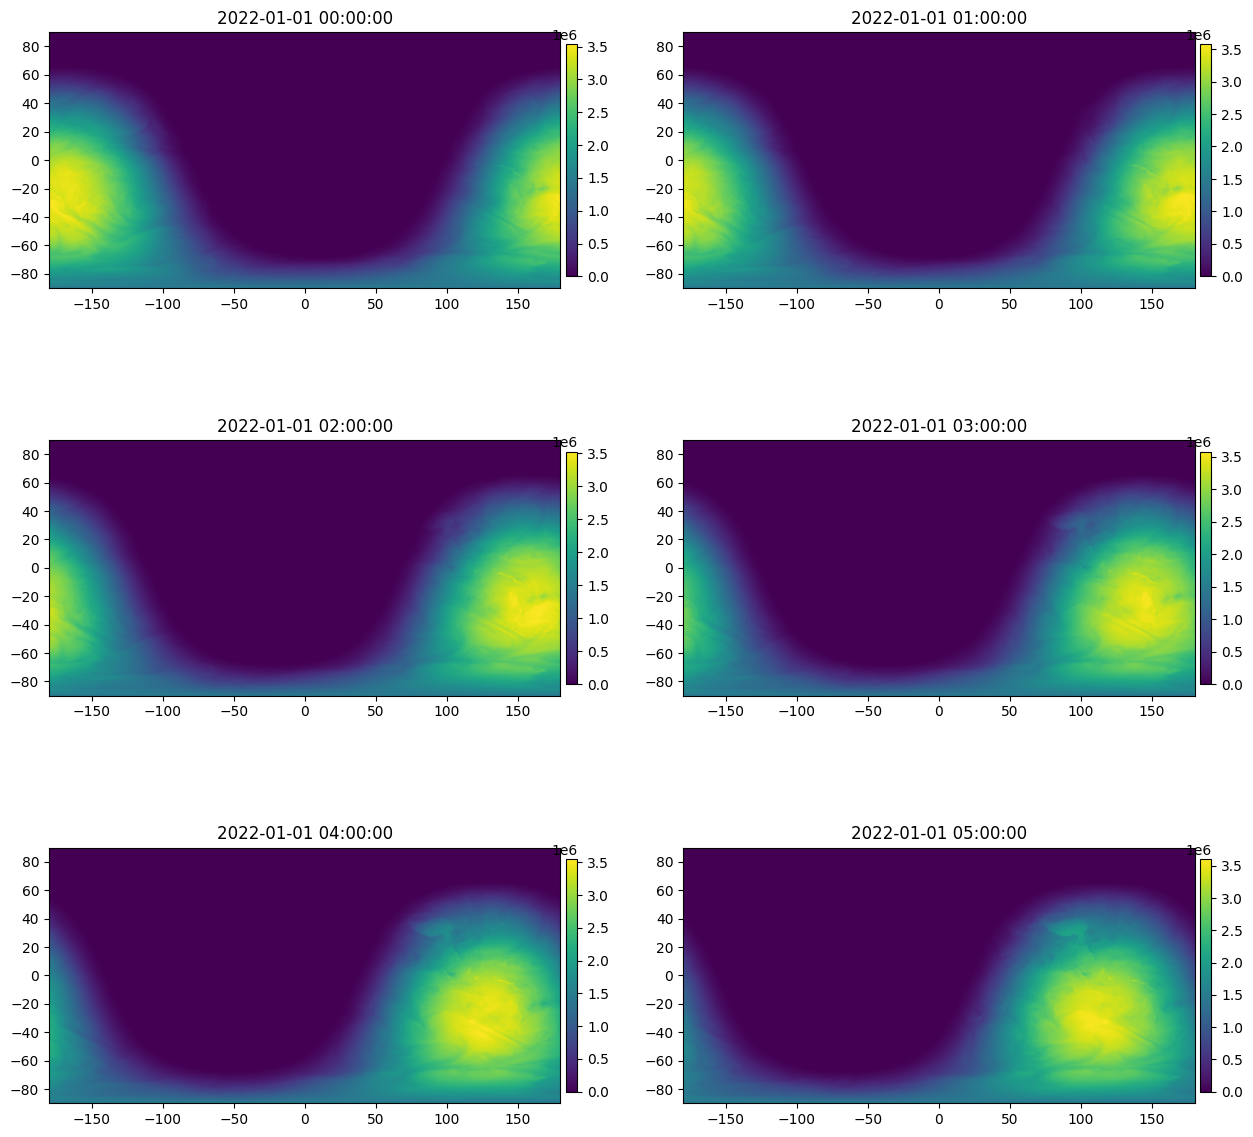

In [186]:
plot_time_intervals('cdir', starting_time) # shows how the sun radiates onto the earth at 12:00am GMT

In [200]:
def plot_time_intervals(variable, starting_time, intervals=6, columns=2, rows=3, d=1):
    columns = int(intervals / rows)
    fig = plt.figure(figsize=(15, 15))
    delta = datetime.timedelta(hours=d)

    for i in range(1, columns*rows + 1):
        time_slice = starting_time + delta * (i - 1)
        variable_data = center_at_prime_meridean(dataset.sel(time=time_slice)[variable].values)
        fig.add_subplot(rows, columns, i, title=time_slice)

        overlay = plt.imread('./world_scaled_for_lat_long.png')[145:455, 99:721]
        plt.imshow(overlay, extent=[-180,180,-90,90])
        im = plt.imshow(variable_data, extent=[-180,180,-90,90], alpha=0.8)
        plt.colorbar(im, fraction=0.022, pad=0.01)

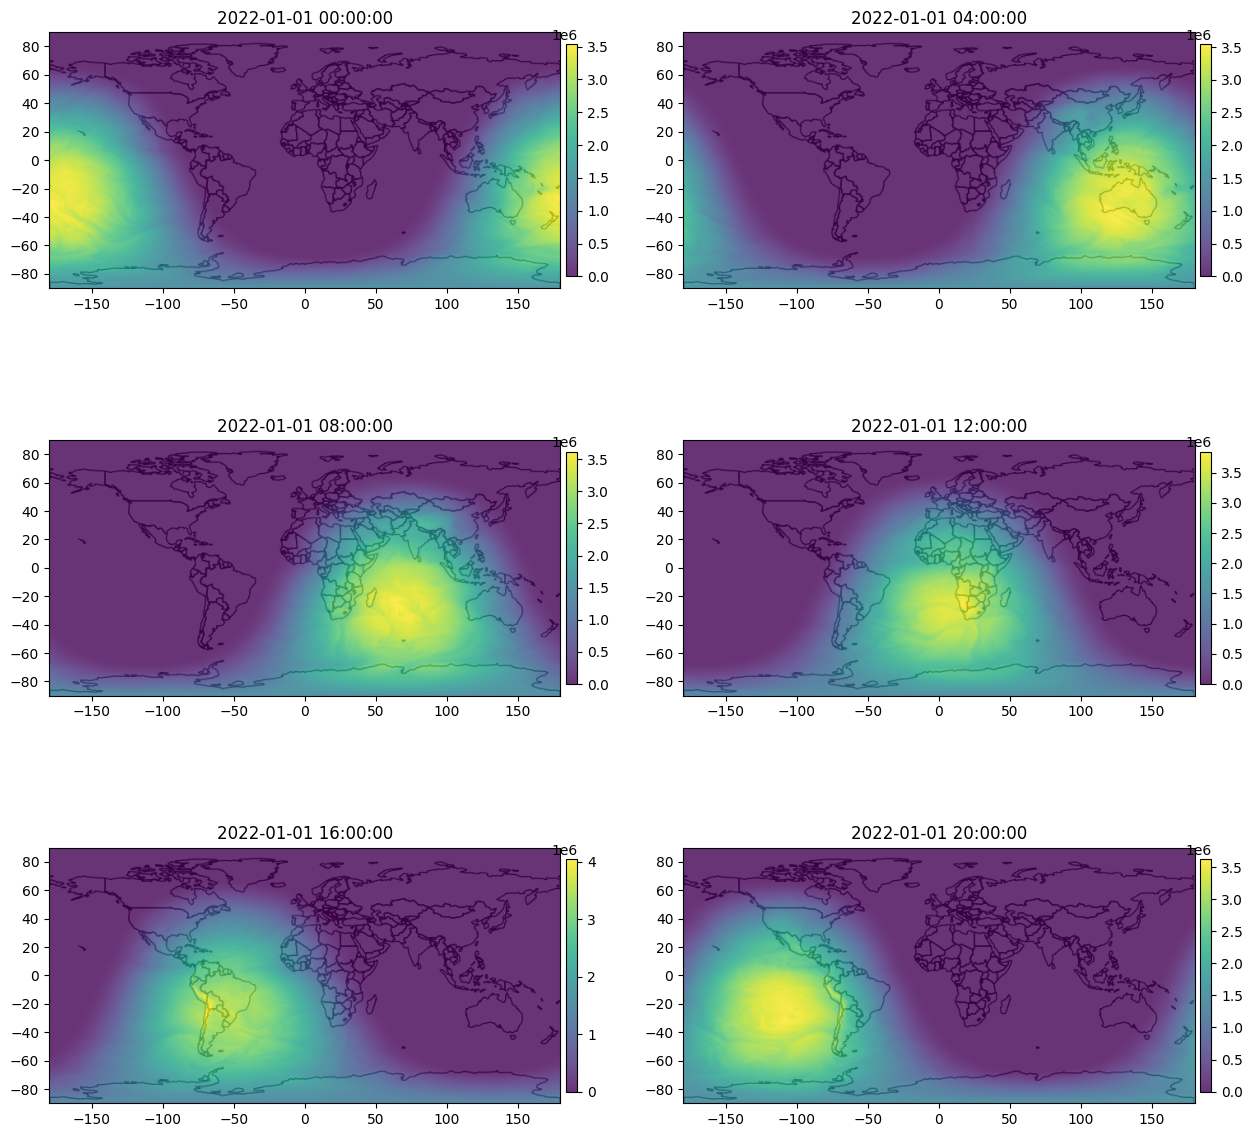

In [203]:
plot_time_intervals('cdir', starting_time, d=4)

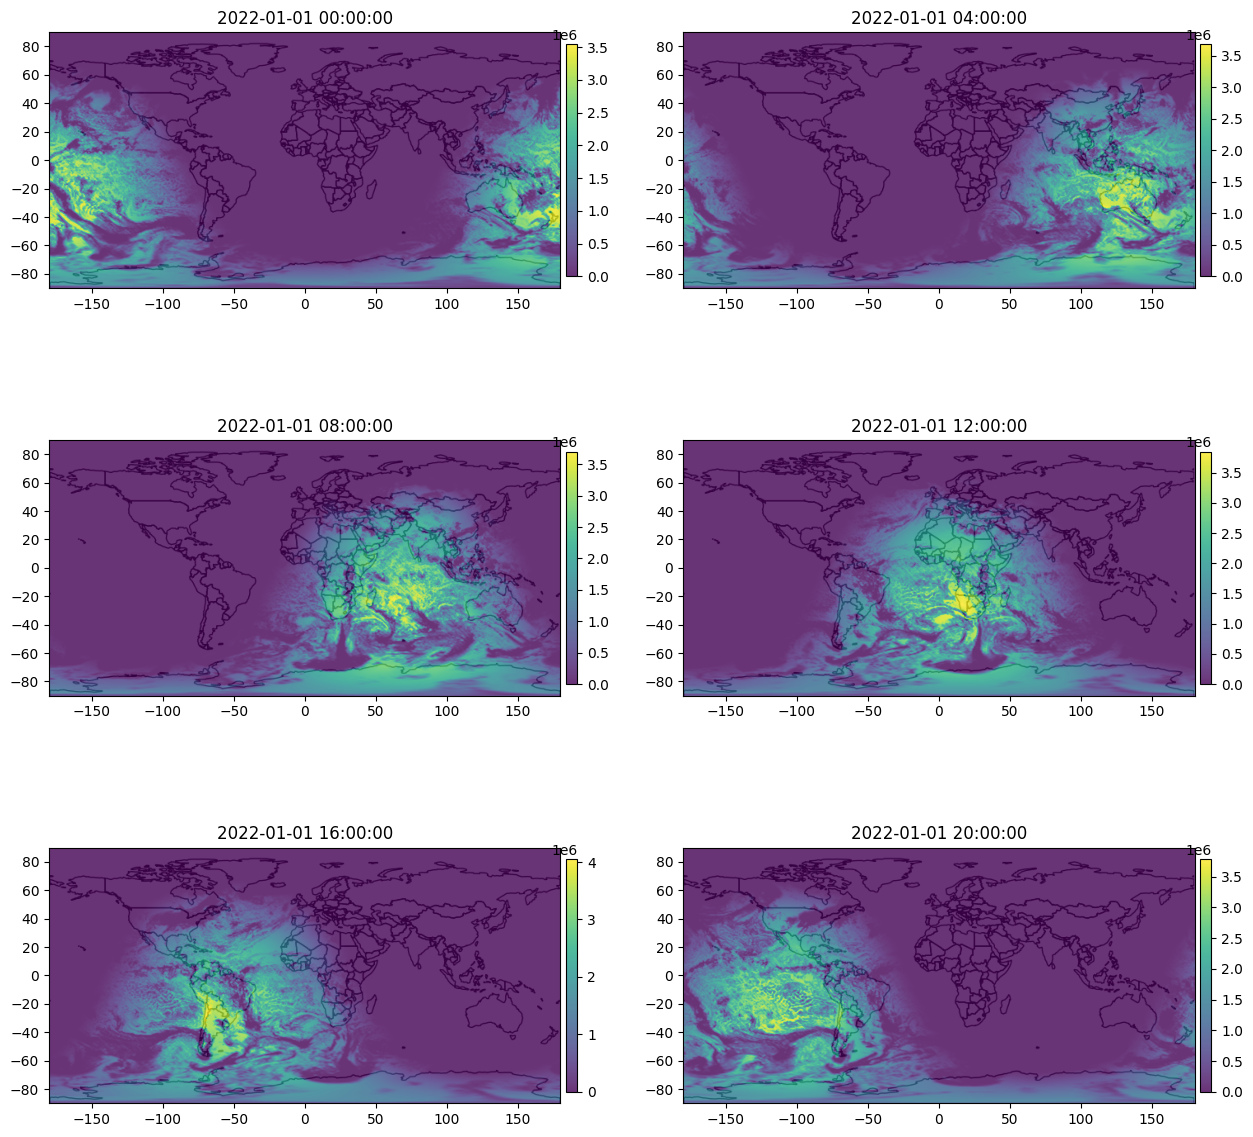

In [256]:
plot_time_intervals('fdir', starting_time, d=4)

On a side note, lets try to explore the differences between cdir and tdir - which may be quite useful for our PV predictions. Below, it seems as if fdir is similar to cdir - tcc * scale_factor. Perhaps we can extropolate fdir from cdir and tcc or the other way around when we create our model?

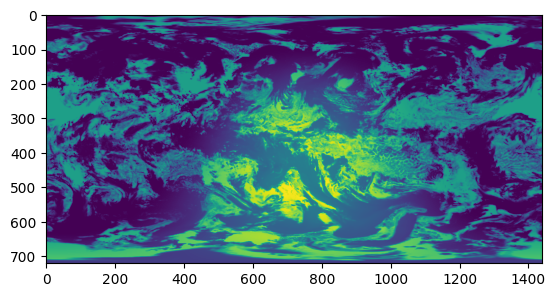

In [283]:
scale_factor = 4500000
tcc = dataset.sel(time=starting_time)['tcc'].values
cdir = dataset.sel(time=starting_time)['cdir'].values
plt.imshow(cdir - (tcc * scale_factor))

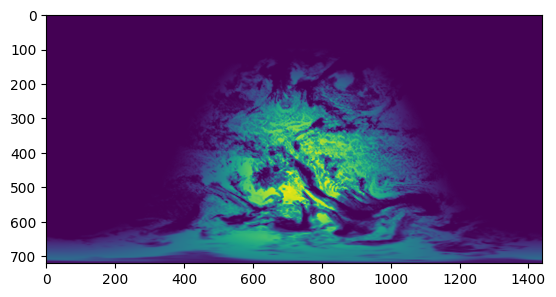

In [272]:
fdir = dataset.sel(time=starting_time)['fdir'].values
plt.imshow(fdir)

Back to visualizations, lets create a function to crop the images to visualize a more specific area.

In [218]:
def plot_time_cropped(variable, starting_time, b, t, l, r):
    new_b = int(360 + 360 * (b/90))
    new_t = int(360 + 360 * (t/90))
    new_l = int(1440 * (l / 360))
    new_r = int(1440 * (r/ 360))
    variable_data = center_at_prime_meridean(dataset.sel(time=starting_time)[variable].values)[new_b:new_t, new_l:new_r]
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    im = plt.imshow(variable_data, extent=[l, r, b, t])
    plt.colorbar(im, fraction=0.022, pad=0.01)

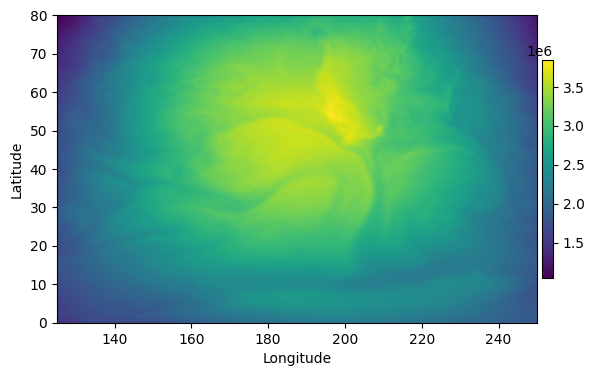

In [223]:
plot_time_cropped('cdir', starting_time + datetime.timedelta(hours=12), 0, 80, 125, 250)

Finally, an extra, lets figure out a way to see which variables may be worth taking and which aren't. Lets start by visualizing the correlation coefficients between the variables.

In [245]:
skt = cp.asarray(dataset['skt'].values).mean(axis=0)
t2m = cp.asarray(dataset['t2m'].values).mean(axis=0)
z = cp.asarray(dataset['z'].values).mean(axis=0)

Lets start with the correlation coeff matrix of "skt" and "t2m". As seen below, they are pretty strongly correlated. This is evident since skt is skin temperature and t2m is 2-metre temperature. Both of which should be similar at the very least. Thus our model shouldn't take in/output both t2m and skt since that may be redundant.

In [246]:
corr = cp.corrcoef(skt, t2m)

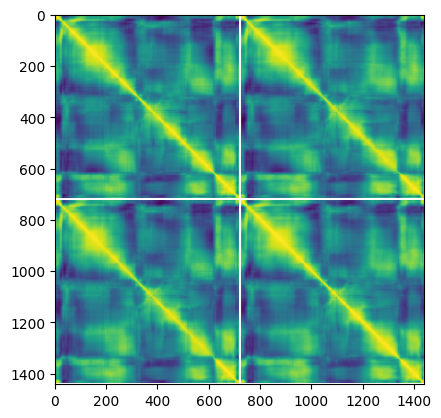

In [247]:
plt.imshow(cp.asnumpy(corr))

Below, we can see that skin 2-metre temp is uncorrelated with geopotential. With the PV data, we can find which variables are correlated with the PV data.

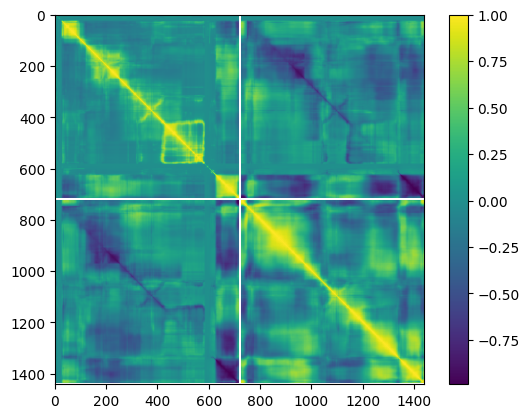

In [249]:
im = plt.imshow(cp.asnumpy(cp.corrcoef(z, t2m)))
plt.colorbar(im)

Seen below, cdir (suns radiation assuming clear skies) and fdir (suns radiation) are slightly correlated, but not as much as skt and t2m.

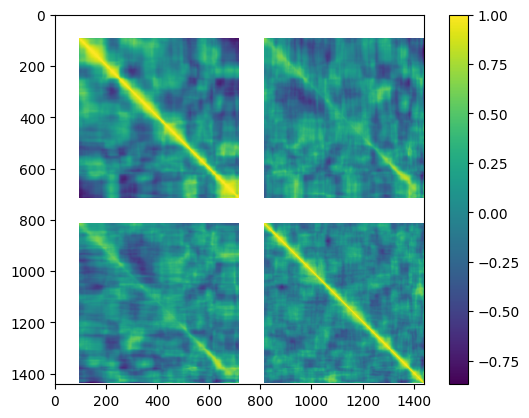

In [257]:
cdir = cp.asarray(dataset['cdir'].values).mean(axis=0)
fdir = cp.asarray(dataset['fdir'].values).mean(axis=0)

im = plt.imshow(cp.asnumpy(cp.corrcoef(cdir, fdir)))
plt.colorbar(im)